<a target="_blank" href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/OU_process/Models/standard_pinn_curriculum_training.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import torch
import torch.nn as nn
from torch.nn import ReLU
from torch.utils.data import Dataset, DataLoader
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.integrate as integrate
import scipy.special as special
import scipy.ndimage as ndimage

# Solving for the MET of an Ornstein-Uhlenbeck process in a disk with "Curriculum trained PINNs": comparison with exact solution

## 1) Setup

For $\theta,\sigma,r >0$ some fixed parameters, we let $\Omega := B_r \equiv \{x\in\mathbb R^d : \|x\|< r \}$, and define the process ($d=2$ in our illustration) :

$$\begin{cases} dX_t &= -\theta X_t dt + \sigma dB_t \\
X_0 &= x \in \Omega \end{cases} $$

For all $x\in\Omega$, let

$$T(x) := \inf\{t\ge 0 : X_t \in\partial\Omega\} $$

and let its first moment be denoted

$$\tau(x) := \mathbb E[T(x)] $$

We can show under some regularity conditions on $\Omega$ that $\tau$ is the (unique) solution of the BVP :

$$\begin{cases} -\mathcal{L}u(x) &= 1 \text{ for all } x\in\Omega \\
u(x) &= 0 \text{ for all } x\in\partial\Omega \end{cases} $$

where $\mathcal L$ is the infinitesimal generator of the Ornstein-Uhlenbeck process, given by
$$\mathcal Lu : x \mapsto -\theta x \cdot \nabla u(x) + \frac{\sigma^2}{2}\Delta u(x) $$

Nicely enough, for this problem, we can compare our solution with the known closed-form solution (see https://arxiv.org/abs/2208.04029) :

$$ \tau(x) := \frac{1}{\lambda^{d/2}\sigma^2}\int_\rho^r z^{1-d} e^{\lambda z^2} \gamma(d/2, \lambda z^2)\ dz $$

where $\lambda := \theta/\sigma^2 $, $\rho := \|x\| $ and $\gamma$ is the upper incomplete gamma function :
$$\gamma(n,y) := \int_0^y t^{n-1} e^{-t}\ dt.  $$

In [2]:
#radius of the ball
radius = 2

#parameters of the OU process
theta = 3 #smaller theta => easier problem
sigma = 1 #larger sigma  => easier problem
lambda_ = theta/sigma**2

#definition of the true solution for comparison

def true_solution(x, y, theta=theta, lambda_=lambda_):
    rho = np.sqrt(x**2 + y**2)
    integral, _ = integrate.quad(lambda t : np.exp(lambda_ * t**2) * special.gammainc(1, lambda_ * t**2) / t, rho, radius)
    return integral/theta

#make the true_solution compatible with numpy arrays
true_solution_vectorized = np.vectorize(true_solution)

#plotting the function
n_points = 300
tt = np.linspace(-1, 1, n_points) * radius
xx, yy = np.meshgrid(tt, tt)  # create unit square grid

xx, yy = np.where(xx**2 + yy**2 <= radius**2, xx, 0), np.where(xx**2 + yy**2 <= radius**2 , yy, 0)
zz = true_solution_vectorized(xx,yy)

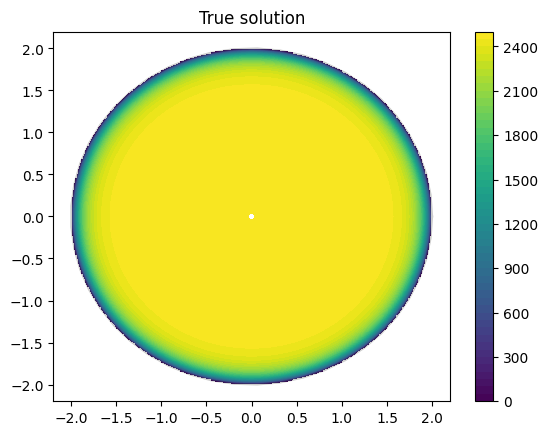

In [3]:
#circle
a = np.linspace(0, 2*np.pi, 50)
cx,cy = np.cos(a) * radius , np.sin(a)*radius

fig, ax = plt.subplots()
ax.plot(cx, cy,'k-', alpha=.2)

contour = ax.contourf(xx, yy, zz, levels=50)  # 50 contour levels
ax.set_title("True solution")
cb = fig.colorbar(contour, ax=ax)

Text(0.5, 1.0, 'True solution along the x=0 axis:')

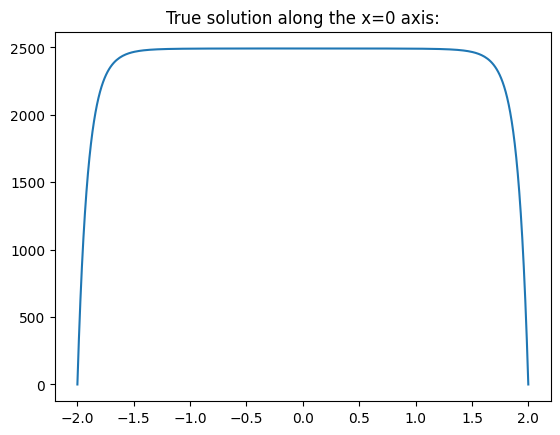

In [4]:
fig, ax = plt.subplots()
ys = true_solution_vectorized(np.zeros_like(tt),tt)
ax.plot(tt,ys)
ax.set_title("True solution along the x=0 axis:")

We can see that for $\theta/\sigma^2 \gg 1$, the true solution blows up extremely fast away from the boundary, and is thus likely to be hard to learn.

## 2) Setting up the Neural Network architecture and loss function

Unlike the standard PINN, we will take an hypothesis space of Neural Networks which satisfy the boundary conditions explicitly. For this problem, we have homogenous zero Dirichlet boundary conditions, which we can enforce by multiplying our Neural Networks with an appropriate "smooth distance approximation" (see https://arxiv.org/abs/2104.08426). In accordance with the mentioned paper, we will take
$$\varphi : x\mapsto \frac{r^2 - \|x\|^2}{2r}$$
as our smooth distance approximation.  


With this modification, our objective to minimize becomes
$$\hat u := \arg\min_{u\in\mathcal{NN}_\varphi}\ \frac1n \sum_{i=1}^n (\mathcal L u(x_i^c) + 1)^2 $$
where $x_i^c$ are sampled i.i.d. with uniform distribution on $\Omega$,
$$\mathcal{NN}_\varphi:=\left\{x\mapsto \varphi(x) \cdot T_L\circ \sigma^k \circ T_{L-1}\circ\cdots\circ \sigma^k\circ T_1 (x)\right\}, $$
for
$$T_\ell : \mathbb{R}^{\ell-1}\to\mathbb{R}^\ell $$
affine-linear maps of appropriate input-output dimensions, where
$$\sigma_k :x \mapsto \begin{cases}x^k &\text{ if } x\ge 0\\ 0 &\text{ if } x\le 0\end{cases} $$
is the ReLU$^k$ activation, which is understood element-wise when applied to vectors.

In [5]:
#define our NN architecture
power = 2 #exponent k for relu^k
width = 50
depth = 3
magnitude = 0.8 #magnitude of weights at initialization

#define ReLU^k activation

class RePU(nn.Module):
    def __init__(self, power = power):
        super(RePU, self).__init__()
        self.power = power

    def forward(self, x):
        return torch.pow(torch.relu(x), self.power)


#define the smooth distance approximation
def smooth_distance(x):
    norm_x = torch.linalg.norm(x, dim=-1)
    return (radius**2 - norm_x**2)/(2*radius)


#define hypothesis space
class CurriculumPINN(nn.Module):
    def __init__(self, power = 2, width = width):
        super(CurriculumPINN,self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, width))
        self.layers.append(RePU(power))
        for _ in range(depth-1) :
            self.layers.append(nn.Linear(width, width))
            self.layers.append(RePU(power))
        self.layers.append(nn.Linear(width, 1))


    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        distance =  smooth_distance(x)
        return output * distance.unsqueeze(-1)


In [6]:
#all functions needed for training

def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    """
    This function calculates the derivative of the model at x
    """
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs = torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy

def u_function(model: CurriculumPINN, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """
    This function evaluates the model on the input x
    """
    model_input = torch.stack((x, y), axis = 1)
    return model(model_input)


def residual(model, x_c, y_c, theta, sigma):
    u = u_function(model, x_c, y_c)
    u_x = derivative(u, x_c, order=1)
    u_y = derivative(u, y_c, order=1)
    u_xx = derivative(u, x_c, order=2)
    u_yy = derivative(u, y_c, order=2)
    res = - theta * (x_c * u_x + y_c * u_y) \
        + sigma**2 * (u_xx + u_yy)/2 \
        + 1
    return res

def loss_function(model: CurriculumPINN, x_c: torch.Tensor, y_c: torch.Tensor, theta, sigma) -> torch.Tensor:
    """
    This function evaluates the physics governing the model on the input x
    """
    res = residual(model, x_c, y_c, theta, sigma)
    return torch.mean(res**2)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight, gain=magnitude)
        m.bias.data.fill_(magnitude)

## 3) Verification of the collocation points for training

sampling $n = N_c$ collocation points in $\Omega$.

In [7]:
N_c = 2048 #number of points in the domain

#definition of X_c_train : N_c points in the disk
t = np.random.uniform(0,2*np.pi, N_c)
rho = np.sqrt(np.random.uniform(0,radius**2, N_c)) #uniform distribution on the disk
x_c = rho * np.cos(t)
y_c = rho * np.sin(t)
X_c_train = np.vstack( (x_c, y_c) )

#shuffling X_c_train
index = np.arange(0, N_c)
np.random.shuffle(index)
X_c_train = X_c_train[:,index]

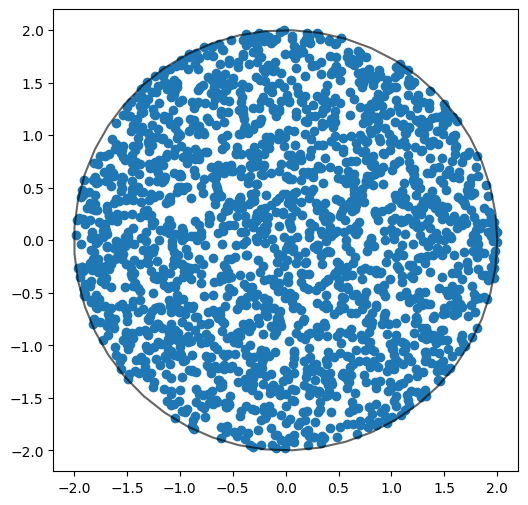

In [8]:
#checking the collocation points
plt.figure(figsize=(6, 6))
plt.plot(cx,cy,'k-', alpha=.6)
plt.scatter(x_c,y_c)

In [9]:
class TrainingData(Dataset):
    def __init__(self, X_c):
        self.X_c = X_c

    def __len__(self):
        return self.X_c.shape[1]

    def __getitem__(self, index):
        X_c = self.X_c[:, index]
        return X_c

## 4) Training loop function

In [10]:
def train_one_epoch(model, optimizer, theta, sigma, losses):
    running_loss = 0.
    last_loss = 0.
    n_display = (N_c//batch_size)//3

    for i, X_c in enumerate(dataloader):

        x_c = X_c[0,:]
        y_c = X_c[1,:]

        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss = loss_function(model, x_c, y_c, theta, sigma)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if (i+1) % n_display == 0 :
            last_loss = running_loss / n_display # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            losses.append(last_loss)
            running_loss = 0.

    return last_loss

## 5) Curriculum training

In [11]:
nb_curriculum = 30
thetas = [theta] * nb_curriculum
sigmas = np.linspace(theta * nb_curriculum, sigma, nb_curriculum).tolist()
losses = [[] for _ in range(nb_curriculum)]

#training parameters
batch_size = 32
learning_rate_adam = 5e-4
learning_rate_sgd = 5e-2
method = 'Adam' #'SGD' or 'Adam', Adam strongly recommended
n_epochs = 1500
n_decreases = 10
damping = 1e-2
gamma = damping**(1/n_decreases) #damp the learning rate by 1e-2 by the end of training

#first training batch

#convert numpy array to tensor and load it
X_c_train_tensor = torch.from_numpy(X_c_train).requires_grad_(True).float()
dataset = TrainingData(X_c_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size)

In [ ]:
for i in range(nb_curriculum):

    print("------CURRICULUM TRAINING: {0}/{1}------".format(i+1, nb_curriculum))

    #update parameter values
    theta = thetas[i]
    sigma = sigmas[i]

    #load model and set optimizer
    model = CurriculumPINN()
    if i > 0:
        model.load_state_dict(\
        torch.load(f'curriculum_pinn_{method}.pt'))
    else:
        model.apply(init_weights)

    if method == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_adam)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs//n_decreases,
                                                gamma=gamma)

    elif method == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate_sgd)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=n_epochs//n_decreases,
                                                gamma=gamma)

    #train model for current curriculum
    epoch_number = 0

    for epoch in range(n_epochs):
        epoch_number += 1
        print('EPOCH {}:'.format(epoch_number))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model, optimizer, theta, sigma, losses[i])
        scheduler.step()
        print('LOSS train {}'.format(avg_loss))

    #save trained model and reset optimizer
    torch.save(model.state_dict(), f'curriculum_pinn_{method}.pt')

    #regenerate collocation points
    #definition of X_c_train : N_c points in the disk
    t = np.random.uniform(0,2*np.pi, N_c)
    rho = np.sqrt(np.random.uniform(0,radius**2, N_c)) #uniform distribution on the disk
    x_c = rho * np.cos(t)
    y_c = rho * np.sin(t)
    X_c_train = np.vstack( (x_c, y_c) )
    #shuffling X_c_train
    index = np.arange(0, N_c)
    np.random.shuffle(index)
    X_c_train = X_c_train[:,index]

    #convert numpy array to tensor and load it
    X_c_train_tensor = torch.from_numpy(X_c_train).requires_grad_(True).float()
    dataset = TrainingData(X_c_train_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  batch 63 loss: 1.819725426344121e-05
LOSS train 1.819725426344121e-05
EPOCH 557:
  batch 21 loss: 2.3163576746095975e-05
  batch 42 loss: 1.5173729505726269e-05
  batch 63 loss: 1.5596501706719817e-05
LOSS train 1.5596501706719817e-05
EPOCH 558:
  batch 21 loss: 2.410440639605007e-05
  batch 42 loss: 1.5994772307218835e-05
  batch 63 loss: 1.828786901114654e-05
LOSS train 1.828786901114654e-05
EPOCH 559:
  batch 21 loss: 2.2830576497090944e-05
  batch 42 loss: 1.5374795523149216e-05
  batch 63 loss: 1.8131594933785372e-05
LOSS train 1.8131594933785372e-05
EPOCH 560:
  batch 21 loss: 2.26764759916131e-05
  batch 42 loss: 1.5777254605252112e-05
  batch 63 loss: 1.7687303037898044e-05
LOSS train 1.7687303037898044e-05
EPOCH 561:
  batch 21 loss: 2.3580091947007443e-05
  batch 42 loss: 1.5744814293481924e-05
  batch 63 loss: 1.801302622084222e-05
LOSS train 1.801302622084222e-05
EPOCH 562:
  batch 21 loss: 2.2016347342980

## 6) Visualizing the training

In [1]:
fig, axs = plt.subplots(1,3)
axs[0,0].loglog(losses[nb_curriculum//3])
axs[0, 0].set_title('Training loss ({2}): curriculum {0}/{1}'.format(nb_curriculum//3,nb_curriculum,method))
axs[0,1].loglog(losses[2 * nb_curriculum//3])
axs[0, 1].set_title('Training loss ({2}): curriculum {0}/{1}'.format(2 * nb_curriculum//3,nb_curriculum,method))
axs[0,2].loglog(losses[nb_curriculum])
axs[0, 2].set_title('Training loss ({1}): curriculum {0}/{0}'.format(nb_curriculum,method))
plt.show()

NameError: name 'plt' is not defined

## 7) Visualizing the results

In [ ]:
#load the model
model = CurriculumPINN()
model.load_state_dict(\
torch.load(f'curriculum_pinn_{method}.pt'))

#evaluate the model on a uniform grid
n_points = 150
tt = np.linspace(-1, 1, n_points) * radius
xx, yy = np.meshgrid(tt, tt)  # create unit square grid
xx, yy = np.where(xx**2 + yy**2 <= radius**2, xx, 0), np.where(xx**2 + yy**2 <= radius**2 , yy, 0) #(https://stackoverflow.com/questions/15733530/)
#zz_true = true_solution_vectorized(xx,yy)

input = torch.from_numpy(np.vstack((xx.ravel(),yy.ravel())).T).float()#.requires_grad_(False)
learned_sol = model(input)

#plot
learned_sol_np = learned_sol.detach().numpy().reshape(xx.shape)
#learned_sol_smooth = ndimage.gaussian_filter(learned_sol_np, sigma=0.1, order=0) #smoothing for visualization

fig, ax = plt.subplots()
ax.plot(cx, cy,'k-', alpha=.2)
contour = ax.contourf(xx, yy, learned_sol_np, levels=200)
ax.set_title(f'Curriculum PINN solution ({method})')
cb = fig.colorbar(contour, ax=ax)

In [ ]:
#verify that the model is zero on the boundary
circle = torch.from_numpy(np.vstack((cx.ravel(),cy.ravel())).T).float().requires_grad_(False)
torch.sum(model(circle)**2) #== 0